In [1]:
import pandas as pd
from datetime import datetime

In [2]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))


[]


In [3]:
print(tf.__version__)

2.10.1


In [4]:
df = pd.read_csv('../data/current.csv')
# df = pd.read_csv('../../training_data.csv')
df.head()
df.shape


(5281, 42)

### Cleaning

In [5]:
df.drop(df['skaterFullName'].loc[df['skaterFullName'] == 'Taylor Hall'].index, inplace=True)
df = df.drop(columns=['skaterFullName', 'teamAbbrevs', 'vs', 'shoots', 'row', 'date']) 
df = df.dropna()
df.head()

,ppPoints,gamesPlayed,position,ppUnit,avgPowerplayToi,team_PEN/GP,team_PP%,team_PK%,team_G,team_GA,...,PPGF_enemy,PPG/PG_enemy,PPO/PG_enemy,PPTOI/PG_enemy,PEN_enemy,PENMin_enemy,PENSeconds/PG_enemy,PENDrawn/GP_enemy,PPGA_enemy,PKTIO/PG_enemy
2133,0,16,L,2.0,01:46,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2134,4,24,C,1.0,02:10,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2135,3,26,C,1.0,03:14,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2137,3,26,R,2.0,01:51,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2138,2,26,D,1.0,01:43,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666


In [6]:
df['avgPowerplayToi'] = df['avgPowerplayToi'].apply(lambda x: datetime.strptime(str(x), "%M:%S").second + datetime.strptime(str(x), "%M:%S").minute * 60)


df['position'].replace(['C', 'R', 'L', 'D'], [2, 2, 2, 1], inplace=True)
df.head()

,ppPoints,gamesPlayed,position,ppUnit,avgPowerplayToi,team_PEN/GP,team_PP%,team_PK%,team_G,team_GA,...,PPGF_enemy,PPG/PG_enemy,PPO/PG_enemy,PPTOI/PG_enemy,PEN_enemy,PENMin_enemy,PENSeconds/PG_enemy,PENDrawn/GP_enemy,PPGA_enemy,PKTIO/PG_enemy
2133,0,16,2,2.0,106,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2134,4,24,2,1.0,130,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2135,3,26,2,1.0,194,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2137,3,26,2,2.0,111,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666
2138,2,26,1,1.0,103,4.017515,0.15789,0.81176,74.0,90.0,...,18.0,0.75,3.29166,305.458333,110.0,258.0,645.0,4.029789,10.0,368.791666


### Visualization

Players who scored:  576
Players who did not score:  2490


C:\Users\Logan\AppData\Local\Temp\ipykernel_16036\326808471.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=concat, data=df, palette='hls')


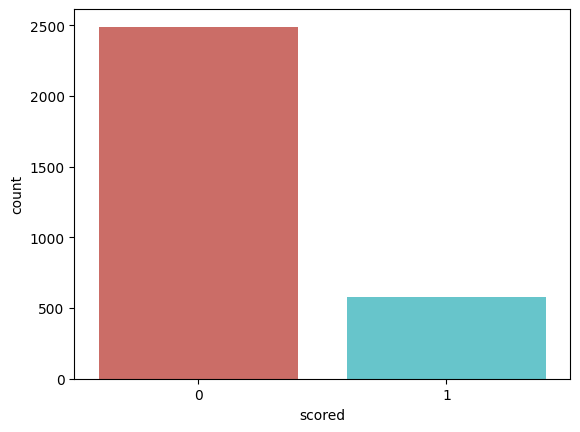

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

labels=['scored', 'no-score']

scored = df[df['scored'] == 1]['scored']
no_score = df[df['scored'] == 0]['scored']

concat = pd.concat([scored, no_score])

sns.countplot(x=concat, data=df, palette='hls')
print('Players who scored: ', len(scored))
print('Players who did not score: ', len(no_score))

In [8]:
perc = (scored.shape[0] / df['scored'].shape[0]) * 100
print(f'Percentage of players with a scored point ({scored.shape[0]}/{df["scored"].shape[0]}): {round(perc, 2)}%')

Percentage of players with a scored point (576/3066): 18.79%


### Neural Network

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense, LSTM, Dropout, Conv1D, MaxPooling1D, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from keras.callbacks import EarlyStopping


In [10]:
# from sklearn.model_selection import GridSearchCV
# from keras.wrappers.scikit_learn import KerasClassifier
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import RandomOverSampler
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
# import tensorflow as tf

# # Define features and biases
# features = ['ppPoints', 'gamesPlayed', 'avgPowerplayToi', 'team_PEN/GP', 'team_PP%', 'team_PK%', 'team_GA', 'team_G', 'enemy_PEN/GP', 'enemy_PP%', 'enemy_PK%', 'enemy_GA', 'enemy_G']

# biases = {
#     'ppPoints': 2.5,
#     'gamesPlayed': 0.5,
#     'avgPowerplayToi': 2.6,
#     'team_PEN/GP': 0.0,
#     'team_PP%': 2.5,
#     'team_PK%': 0.0,
#     'team_GA': 0.0,
#     'team_G': 0.3,
#     'enemy_PEN/GP': 2.5,
#     'enemy_PP%': 0.0,
#     'enemy_PK%': 2.6,
#     'enemy_GA': 0.4,
#     'enemy_G': 0.0
# }

# # Preprocess data
# scaler = StandardScaler()
# scaler.fit(df[features])
# df[features] = scaler.transform(df[features])

# # Apply biases if needed
# # df[features] = df[features].apply(lambda x: x + biases[x.name])

# X = df[features].values
# y = df['scored'].values

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# # Fit and transform the training data using the RandomUnderSampler
# # X_train, y_train = undersampler.fit_resample(X_train, y_train)
# X_train, y_train = oversampler.fit_resample(X_train, y_train)

# # Reshape data for CNN
# X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
# X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# # Define the CNN model creation function
# def create_cnn_model(filters=64, kernel_size=5, dense_units=512, pool_size=2, epochs=65, batch_size=256):
#     model = Sequential()
#     model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu', input_shape=(X_train.shape[1], 1)))
#     model.add(Dense(dense_units, activation='relu'))
#     model.add(MaxPooling1D(pool_size=pool_size))
#     model.add(Flatten())
#     model.add(Dense(1, activation='sigmoid'))
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision()])
#     return model

# # Create KerasClassifier for use in scikit-learn GridSearchCV
# cnn_model = create_cnn_model()
# cnn_classifier = KerasClassifier(build_fn=create_cnn_model, verbose=1)

# # Define the hyperparameters to tune
# param_grid = {
#     'filters': [32, 64, 128],
#     'kernel_size': [3, 5, 7],
#     'dense_units': [256, 512, 1024],
#     'pool_size': [2, 3, 4],
#     'epochs': [50, 65, 80],             # Example: Number of training epochs
#     'batch_size': [128, 256, 512],
# }

# # Create GridSearchCV
# grid = GridSearchCV(estimator=cnn_classifier, param_grid=param_grid, scoring='precision', cv=3)
# grid_result = grid.fit(X_train, y_train)

# # Summarize results
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# # Create a model with the best parameters
# best_params = grid_result.best_params_
# best_cnn_model = create_cnn_model(
#     filters=best_params['filters'],
#     kernel_size=best_params['kernel_size'],
#     dense_units=best_params['dense_units'],
#     pool_size=best_params['pool_size']
# )

# # Train the best model
# history = best_cnn_model.fit(X_train, y_train, epochs=65, batch_size=300, validation_data=(X_test, y_test), verbose=1, shuffle=True)


In [11]:
features = ['ppPoints', 'gamesPlayed', 'avgPowerplayToi', 'team_PEN/GP', 'team_PP%', 'team_PK%', 'team_GA', 'team_G', 'enemy_PEN/GP', 'enemy_PP%', 'enemy_PK%', 'enemy_GA', 'enemy_G']

# 35 Features
features = ['ppPoints', 'gamesPlayed', 'position', 'ppUnit', 'avgPowerplayToi', 'team_G', 'team_GA', 'team_PP%', 'PPGF', 'PPG/PG', 'PPO/PG',
            'PPTOI/PG', 'PEN', 'PENMin', 'team_PEN/GP', 'PENSeconds/PG', 'PENDrawn/GP', 'PPGA', 'team_PK%', 'PKTIO/PG', 'enemy_G', 'enemy_GA', 'enemy_PP%',
            'PPGF_enemy', 'PPG/PG_enemy', 'PPO/PG_enemy', 'PPTOI/PG_enemy', 'PEN_enemy', 'PENMin_enemy', 'enemy_PEN/GP', 'PENSeconds/PG_enemy', 'PENDrawn/GP_enemy',
            'PPGA_enemy', 'enemy_PK%', 'PKTIO/PG_enemy']

biases = {
    'ppPoints': 2.5,
    'gamesPlayed': 0.5,
    'avgPowerplayToi': 2.6,
    'team_PEN/GP': 0.0,
    'team_PP%': 2.5,
    'team_PK%': 0.0,
    'team_GA': 0.0,
    'team_G': 0.3,
    'enemy_PEN/GP': 2.5,
    'enemy_PP%': 0.0,
    'enemy_PK%': 2.6,
    'enemy_GA': 0.4,
    'enemy_G': 0.0
}

# scaler = MinMaxScaler()
# scaler.fit(df[features])
# df[features] = scaler.transform(df[features])

scaler = StandardScaler()
scaler.fit(df[features])
df[features] = scaler.transform(df[features])

# df[features] = df[features].apply(lambda x: x + biases[x.name])

X = df[features].values
y = df['scored'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and transform the training data using the RandomUnderSampler
# X_train, y_train = undersampler.fit_resample(X_train, y_train)
X_train, y_train = oversampler.fit_resample(X_train, y_train)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape)

dense_units = 1024
batch_size = 128
epochs = 65
filters = 128
kernel_size = 7
pool_size = 4

model = Sequential()
model.add(Dense(256, activation='relu'))
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(256, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Precision()])

tf.random.set_seed(42)
history = model.fit(X_train, y_train, epochs=65, batch_size=512, verbose=1, shuffle=True)

(3478, 35, 1)
Epoch 1/65
7/7 [==============================] - 1s 83ms/step - loss: 0.6836 - precision: 0.5793
Epoch 2/65
7/7 [==============================] - 1s 78ms/step - loss: 0.6560 - precision: 0.6144
Epoch 3/65
7/7 [==============================] - 1s 79ms/step - loss: 0.6475 - precision: 0.6372
Epoch 4/65
7/7 [==============================] - 1s 80ms/step - loss: 0.6301 - precision: 0.6613
Epoch 5/65
7/7 [==============================] - 1s 79ms/step - loss: 0.6206 - precision: 0.6452
Epoch 6/65
7/7 [==============================] - 1s 83ms/step - loss: 0.6155 - precision: 0.6760
Epoch 7/65
7/7 [==============================] - 1s 85ms/step - loss: 0.6049 - precision: 0.6842
Epoch 8/65
7/7 [==============================] - 1s 90ms/step - loss: 0.5955 - precision: 0.6660
Epoch 9/65
7/7 [==============================] - 1s 83ms/step - loss: 0.5934 - precision: 0.6828
Epoch 10/65
7/7 [==============================] - 1s 82ms/step - loss: 0.5794 - precision: 0.7095
Epoch

In [12]:
from sklearn.metrics import classification_report

y_pred_probs = model.predict(X_test)

# Adjust the threshold
threshold = 0.9 # You can experiment with different threshold values
y_pred_labels = (y_pred_probs > threshold).astype(int)

print(f'threshold of {threshold*100}%')
print(classification_report(y_test, y_pred_labels))

y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int)
print('Regular threshold')
print(classification_report(y_test, y_pred))

29/29 [==============================] - 0s 3ms/step
threshold of 90.0%
              precision    recall  f1-score   support

           0       0.85      0.95      0.90       751
           1       0.51      0.22      0.31       169

    accuracy                           0.82       920
   macro avg       0.68      0.59      0.60       920
weighted avg       0.78      0.82      0.79       920

29/29 [==============================] - 0s 3ms/step
Regular threshold
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       751
           1       0.45      0.58      0.51       169

    accuracy                           0.79       920
   macro avg       0.68      0.71      0.69       920
weighted avg       0.82      0.79      0.80       920



In [13]:
# model.save('model.h5')

In [14]:
# import matplotlib.pyplot as plt

# plt.plot(history.history['precision'], label='Training Precision')
# plt.plot(history.history['val_precision'], label='Validation Precision')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

## Player List Prediction

In [15]:
# df = pd.read_csv('../../../lib/ai_bum_list.csv')
# df.drop(df['skaterFullName'].loc[df['skaterFullName'] == 'Taylor Hall'].index, inplace=True)
# df = df.drop(columns=['skaterFullName', 'teamAbbrevs', 'vs', 'shoots', 'row', 'date']) 
# df = df.dropna()

# df['avgPowerplayToi'] = df['avgPowerplayToi'].apply(lambda x: datetime.strptime(str(x), "%M:%S").second + datetime.strptime(str(x), "%M:%S").minute * 60)

# df['position'].replace(['C', 'R', 'L', 'D'], [2, 2, 2, 1], inplace=True)
# df.head()
# df.shape

In [16]:
list_df = pd.read_csv('../../../lib/ai_bum_list.csv')

list_df.drop(list_df['skaterFullName'].loc[list_df['skaterFullName'] == 'Taylor Hall'].index, inplace=True)
list_df['avgPowerplayToi'] = list_df['avgPowerplayToi'].apply(lambda x: datetime.strptime(str(x), "%M:%S").second + datetime.strptime(str(x), "%M:%S").minute * 60)
list_df['position'].replace(['C', 'R', 'L', 'D'], [2, 2, 2, 1], inplace=True)

# features = ['ppPoints', 'gamesPlayed', 'avgPowerplayToi', 'team_PEN/GP', 'team_PP%', 'team_PK%', 'team_GA', 'team_G', 'enemy_PEN/GP', 'enemy_PP%', 'enemy_PK%', 'enemy_GA', 'enemy_G']

features = ['ppPoints', 'gamesPlayed', 'position', 'ppUnit', 'avgPowerplayToi', 'team_G', 'team_GA', 'team_PP%', 'PPGF', 'PPG/PG', 'PPO/PG',
            'PPTOI/PG', 'PEN', 'PENMin', 'team_PEN/GP', 'PENSeconds/PG', 'PENDrawn/GP', 'PPGA', 'team_PK%', 'PKTIO/PG', 'enemy_G', 'enemy_GA', 'enemy_PP%',
            'PPGF_enemy', 'PPG/PG_enemy', 'PPO/PG_enemy', 'PPTOI/PG_enemy', 'PEN_enemy', 'PENMin_enemy', 'enemy_PEN/GP', 'PENSeconds/PG_enemy', 'PENDrawn/GP_enemy',
            'PPGA_enemy', 'enemy_PK%', 'PKTIO/PG_enemy']

list_df[features] = scaler.transform(list_df[features])

# Iterate over each row and reshape
reshaped_data_list = []
for index, row in list_df.iterrows():
    reshaped_data = row[features].values.reshape(1, 35, 1)
    reshaped_data_list.append(reshaped_data)


# Convert the list to a NumPy array
reshaped_data_array = np.array(reshaped_data_list, dtype=np.float32)

predictions = []
for i in reshaped_data_array:
    pred = model.predict(i, verbose=0)
    predictions.append(pred[0][0])

# Return scaled data to normal
list_df['prediction'] = predictions

list_df[features] = scaler.inverse_transform(list_df[features])
list_df.sort_values(by='prediction', ascending=False).to_csv('rnn_preds.csv')


In [17]:
ep = list_df[list_df['skaterFullName'] == 'Jason Robertson']
ep[features]

,ppPoints,gamesPlayed,position,ppUnit,avgPowerplayToi,team_G,team_GA,team_PP%,PPGF,PPG/PG,...,PPO/PG_enemy,PPTOI/PG_enemy,PEN_enemy,PENMin_enemy,enemy_PEN/GP,PENSeconds/PG_enemy,PENDrawn/GP_enemy,PPGA_enemy,enemy_PK%,PKTIO/PG_enemy
149,14.0,41.0,2.0,1.0,133.0,150.0,127.0,0.23275,27.0,0.65853,...,3.11904,316.523809,164.0,390.0,3.874854,557.0,3.898482,33.0,0.75555,307.666666


In [18]:
pred_list = pd.read_csv('rnn_preds.csv')


# display = ['skaterFullName', 'teamAbbrevs', 'ppPoints', 'ppUnit', 'team_PP%', 'vs', 'enemy_PP%', 'enemy_PK%', 'prediction', 'odds']
display = ['skaterFullName', 'teamAbbrevs', 'ppPoints', 'ppUnit', 'team_PP%', 'vs', 'enemy_PP%', 'enemy_PK%', 'enemy_PEN/GP', 'prediction']

pred_list['prediction'] = pred_list['prediction'].apply(lambda x: round(x, 5))

threshold = 0.5
# Grab only the top predictions based on the threshold
top_threshold = pred_list[pred_list['prediction'] > threshold]

print(f'Threshold of {threshold*100}%')

Threshold of 50.0%


In [19]:
# odds = [
#     2.0,
#     2.2,
#     2.4,
# ]

# top_threshold['odds'] = odds
top_threshold[display]

,skaterFullName,teamAbbrevs,ppPoints,ppUnit,team_PP%,vs,enemy_PP%,enemy_PK%,enemy_PEN/GP,prediction
0,Kent Johnson,CBJ,-8.881784e-16,NaN,0.14529,SEA,0.20689,0.80869,3.319931,1.00000
1,Adam Boqvist,CBJ,2.000000e+00,NaN,0.14529,SEA,0.20689,0.80869,3.319931,1.00000
2,Elias Pettersson,VAN,1.900000e+01,NaN,0.23529,BUF,0.14166,0.78461,3.807746,1.00000
3,J.T. Miller,VAN,2.300000e+01,NaN,0.23529,BUF,0.14166,0.78461,3.807746,1.00000
4,Wyatt Johnston,DAL,4.000000e+00,NaN,0.23275,CHI,0.12977,0.75555,3.874854,1.00000
5,Logan Cooley,ARI,1.000000e+01,NaN,0.23015,MIN,0.18382,0.72661,4.405837,1.00000
6,Brayden Schenn,STL,5.000000e+00,NaN,0.11965,BOS,0.27200,0.85256,4.532917,1.00000
7,Robby Fabbri,DET,4.000000e+00,NaN,0.21472,LAK,0.19841,0.87069,3.626081,1.00000
8,Rasmus Andersson,CGY,4.000000e+00,NaN,0.12878,VGK,0.21192,0.80000,3.541437,1.00000
9,Kevin Hayes,STL,4.000000e+00,NaN,0.11965,BOS,0.27200,0.85256,4.532917,1.00000
